In [1]:
import numpy as np
from matplotlib import pyplot as plt
from SYK_fft import *
from ConformalAnalytical import *
import testingscripts

In [2]:
testingscripts.realtimeFFT_validator() # Should return True

True

In [3]:
def rhotosigma(rhoG,rhoD,M,dt,t,g,kappa=1,delta=1e-6):
    '''
    returns [Sigma,Pi] given rhos
    '''
    eta = np.pi/(M*dt)*0.1 
    rhoGrev = np.concatenate(([rhoG[-1]], rhoG[1:][::-1]))
    rhoFpp = (1/np.pi)*freq2time(rhoG * fermidirac(beta*omega),M,dt)
    rhoFpm = (1/np.pi)*freq2time(rhoG * fermidirac(-1.*beta*omega),M,dt)
    rhoFmp = (1/np.pi)*freq2time(rhoGrev * fermidirac(beta*(omega)),M,dt)
    rhoFmm = (1/np.pi)*freq2time(rhoGrev * fermidirac(-1.*beta*omega),M,dt)
    rhoBpp = (1/np.pi)*freq2time(rhoD * boseeinstein(beta*(omega+eta)),M,dt)
    rhoBpm = (1/np.pi)*freq2time(rhoD * boseeinstein(-1.*beta*(omega+eta)),M,dt)
    
    argSigma = (rhoFpm*rhoBpm - rhoFpp*rhoBpp) * np.exp(-np.abs(delta*t)) * np.heaviside(t,1)
    Sigma = 1j*(g**2)*kappa * time2freq(argSigma,M,dt)
    
    argPi = (rhoFpp*rhoFmp - rhoFpm*rhoFmm) * np.exp(-np.abs(delta*t)) * np.heaviside(t,1)
    Pi = 2*1j*(g**2) * time2freq(argPi,M,dt)
    
    return [Sigma, Pi]

In [4]:
g = 0.5
mu = 0.
#r = 0.001
r = 0. 

beta = 200.

M = int(2**18) #number of points in the grid
T = 2**14 #upper cut-off fot the time
dt = (2*T)/((2*M))
t = dt * (np.arange(2*M) - M)

dw = np.pi/(M*dt)
#eta = 1.1011011101111011111 * dw * 0.1
#eta = dw*9.
eta = 1e-4*(1./T)

omega = dw * (np.arange(2*M) - M) 
np.testing.assert_almost_equal(dt*dw*M,np.pi,5, "Error in fundamentals")
err = 1e-1
print("omega max = ", omega[-1], "dw = ", dw )
print("dt = ", dt)

#delta = 0.420374134464041
np.testing.assert_almost_equal(np.max(np.abs(omega)),np.pi*M/T,5,"Error in creating omega grid")

omega max =  50.265290709838204 dw =  0.00019174759848570515
dt =  0.0625


In [5]:
#GRomega = (-1j)*np.ones(2*M)
#GRomega = time2freq((-1j)*np.ones(2*M)*np.heaviside(t,1.0),M,dt)
#GRomega = time2freq(GRconf(t+1j*delta,J = Jot,beta = beta),M,dt)
GRomega = 1/(omega + 1j*eta + mu)
DRomega = 1/(-1.0*(omega + 1j*eta)**2 + r)
#DRomega = -1.0*np.ones(2*M)
#DRomega = time2freq(-1.0*np.ones(2*M)*np.heaviside(t,1.0),M,dt)


itern = 0

omegar2 = ret_omegar2(g,beta)

diff = 1 
diffG,diffD = (0.5,0.5)
xG,xD = (0.5,0.5)

while (diff>err and itern<150): 
    if itern<20:
        eta = 10*dw
    else:
        eta = dw*0.01

    itern += 1 
    diffoldG,diffoldD = (diffG,diffD)
    GRoldomega,DRoldomega = (1.0*GRomega, 1.0*DRomega)
    
    rhoG = -1.0*np.imag(GRomega)
    rhoD = -1.0*np.imag(DRomega)
    
    SigmaOmega,PiOmega = rhotosigma(rhoG,rhoD,M,dt,t,g,kappa=1,delta=eta)
    PiOmega[M] = 1.0*r - omegar2
    
    # if itern < 50 : 
    #     PiOmega[M] = 1.0*r - omegar2
   
    GRomega = 1.0*xG/(omega + 1j*eta + mu - SigmaOmega) + (1-xG)*GRoldomega
    DRomega = 1.0*xD/(-1.0*(omega+1j*eta)**2 + r - PiOmega) + (1-xD)*DRoldomega
    
    GRt = (0.5/np.pi) * freq2time(GRomega,M,dt)
    DRt = (0.5/np.pi) * freq2time(DRomega,M,dt)
    #GRt = GRt - np.real(GRt) # make G(t) purely imaginary 
    DRt = DRt - np.imag(DRt) # make D(t) purely real
    GRt[:M] = 0
    DRt[:M] = 0
    #GRt[M] = -1j
    DRt[M] = 0
    
    GRomega = time2freq(GRt,M,dt)
    DRomega = time2freq(DRt,M,dt)
    

   
    #diffG = np. sqrt((0.5/M) * np.sum((np.abs(GRomega-GRoldomega))**2)) #changed
    #diffD = np. sqrt((0.5/M) * np.sum((np.abs(DRomega-DRoldomega))**2))
    diffG = np. sqrt(np.sum((np.abs(GRomega-GRoldomega))**2)) #changed
    diffD = np. sqrt(np.sum((np.abs(DRomega-DRoldomega))**2))
    #diff = np.max([diffG,diffD])
    diff = diffG+diffD
    diffG,diffD = diff,diff
    
    if diffG>diffoldG:
        xG/=2.
    if diffD>diffoldD:
        xD/=2.
    
    
    print("itern = ",itern, " , diff = ", diffG, diffD, " , x = ", xG, xD, end = '\r')
        



/Users/aravindhswaminathan/Documents/GitHub/TwoSidedYSYK/SYK_fft.py:87: RuntimeWarning: overflow encountered in exp
  return (1.0/(1.0 + np.exp(arg)))
/Users/aravindhswaminathan/Documents/GitHub/TwoSidedYSYK/SYK_fft.py:102: RuntimeWarning: overflow encountered in exp
  return (1.0/(np.exp(arg)-1))


In [6]:
GRt = (0.5/np.pi) * freq2time(GRomega,M,dt)
DRt = (0.5/np.pi) * freq2time(DRomega,M,dt)

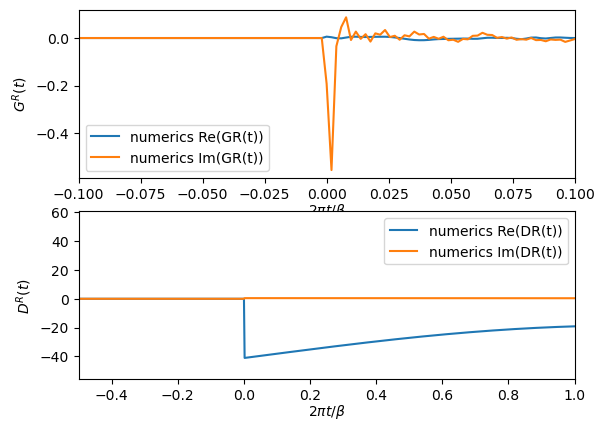

In [7]:
fig, ax = plt.subplots(2)

ax[0].plot(2*np.pi*t/beta, np.real(GRt), label = r'numerics Re(GR(t))')
ax[0].plot(2*np.pi*t/beta, np.imag(GRt), label = r'numerics Im(GR(t))')
#ax[0].plot(tau/beta, np.real(Gconftau), 'b--', label = 'analytical Gtau' )
#ax[0].set_ylim(-1,1)
ax[0].set_xlim(-0.1,0.1)
ax[0].set_xlabel(r'$2\pi t/\beta$',labelpad = 0)
ax[0].set_ylabel(r'${G^R(t)}$')
ax[0].legend()

ax[1].plot(2*np.pi*t/beta, np.real(DRt),'-',label = 'numerics Re(DR(t))')
ax[1].plot(2*np.pi*t/beta, np.imag(DRt), label = 'numerics Im(DR(t))')
#ax[1].plot(tau/beta, np.real(Dconftau), 'b--', label = 'analytical Dtau' )
#ax[1].plot(tau/beta, np.real(FreeDtau), 'g-.', label = 'Free D Dtau' )
#ax[1].set_ylim(0,1)
ax[1].set_xlabel(r'$2\pi t/\beta$',labelpad = 0)
ax[1].set_ylabel(r'${D^R(t)}$')
#ax[1].set_xlim(0,beta/(2*np.pi))
ax[1].set_xlim(-0.5,1)
ax[1].legend()


(3.0110551608966873-0.028394072802883356j)


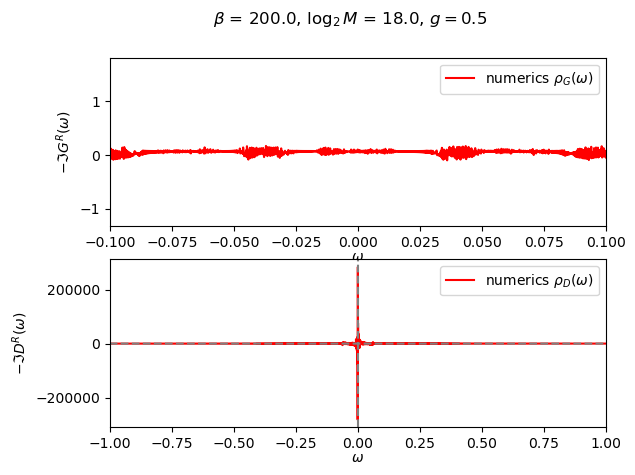

In [8]:
fig, ax = plt.subplots(2)
titlestring = r'$\beta$ = ' + str(beta) + r', $\log_2{M}$ = ' + str(np.log2(M)) + r', $g = $' + str(g)
fig.suptitle(titlestring)

ax[0].plot(omega, rhoG, 'r', label = r'numerics $\rho_G(\omega)$')
#ax[0].plot(tau/beta, np.real(Gconftau), 'b--', label = 'analytical Gtau' )
#ax[0].set_ylim(-1,1)
ax[0].set_xlim(-0.1,0.1)
ax[0].set_xlabel(r'$\omega$',labelpad = 0)
ax[0].set_ylabel(r'$-\Im{G^R(\omega)}$')
ax[0].legend()

ax[1].plot(omega, rhoD, 'r', label = r'numerics $\rho_D(\omega)$')
#ax[1].plot(tau/beta, np.real(Dconftau), 'b--', label = 'analytical Dtau' )
#ax[1].plot(tau/beta, np.real(FreeDtau), 'g-.', label = 'Free D Dtau' )
#ax[1].set_ylim(0,1)
#ax[1].plot(omega,rhoD*boseeinstein(beta*omega), label = 'density of states')
ax[1].set_xlabel(r'$\omega$',labelpad = 0)
ax[1].set_ylabel(r'$-\Im{D^R(\omega)}$')
ax[1].set_xlim(-1,1)
ax[1].legend()
ax[1].plot(omega, np.zeros_like(omega),ls = '--', c = 'gray')
ax[1].axvline([0], ls = '--', c = 'gray')

print(DRomega[-1])

In [9]:
dw, beta 

(0.00019174759848570515, 200.0)

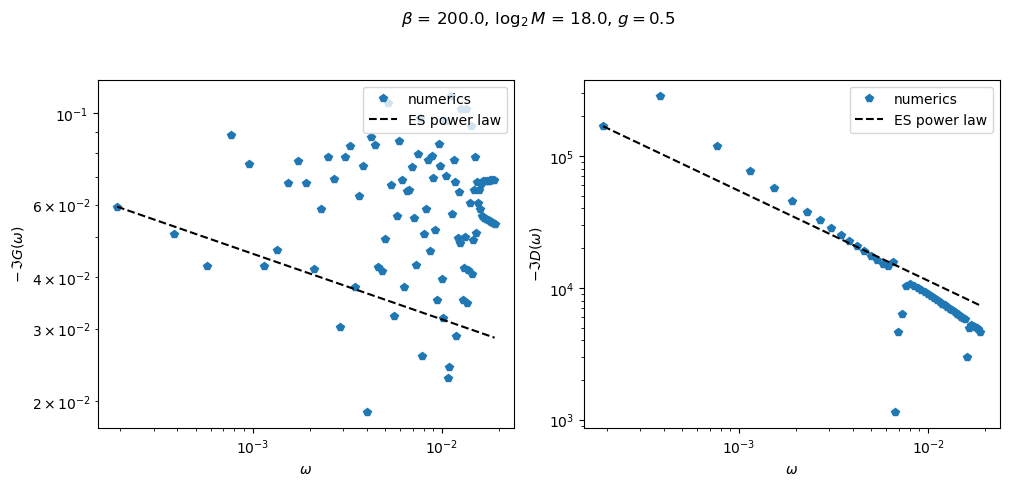

In [10]:
# Delta = 0.42
# powD = 1. - 4*Delta
# plt.loglog(omega[M+1:M+50], np.abs(DRomega[M+1:M+50]),'.') 
# fudfacD = np.abs(DRomega[M+1])/((omega[M+1])**powD)
# plt.loglog(omega[M+1:M+50], fudfacD * (omega[M+1:M+50])**powD)
delta = 0.420374134464041
start,stop = M+1, M+100

fitG_val = -np.imag(GRomega[start])
conf_fit_G = 1 * np.abs(omega+1j*eta)**(2*delta - 1)
conf_fit_G = conf_fit_G/conf_fit_G[start] * fitG_val
#alt_conf_fit_G = fitG_val * np.abs(omega/(g**2))**(2*alt_delta - 1)

fitD_val = -np.imag(DRomega[start])
conf_fit_D = 1 * np.abs(omega[start:stop]+1j*eta)**(1-4*delta)
conf_fit_D = conf_fit_D/conf_fit_D[0] * fitD_val
#alt_conf_fit_D = 1 * np.abs(omega[start:stop])**(1-4*alt_delta)


fig,(ax1,ax2) = plt.subplots(1,2)
fig.set_figwidth(10)
titlestring = r'$\beta$ = ' + str(beta) + r', $\log_2{M}$ = ' + str(np.log2(M)) + r', $g = $' + str(g)
fig.suptitle(titlestring)
fig.tight_layout(pad=2)

ax1.loglog(omega[start:stop], -np.imag(GRomega[start:stop]),'p',label = 'numerics')
ax1.loglog(omega[start:stop], conf_fit_G[start:stop],'k--',label = 'ES power law')
#ax1.loglog(omega[start:], -np.imag(Gconf[start:])*(g**2),'m.',label = 'ES solution')
#ax1.loglog(omega[start:], alt_conf_fit_G[start:],'g--', label = 'alt power law')
#ax1.set_xlim(omega[start]/2,omega[start+15])
#ax1.set_ylim(1e-1,1e1)
ax1.set_xlabel(r'$\omega$')
ax1.set_ylabel(r'$-\,\Im{G(\omega)}$')
#ax1.set_aspect('equal', adjustable='box')
#ax1.axis('square')
ax1.legend(loc = 'upper right')


ax2.loglog(omega[start:stop], -np.imag(DRomega[start:stop]),'p',label='numerics')
ax2.loglog(omega[start:stop], conf_fit_D,'k--',label = 'ES power law')
#ax2.loglog(nu[startB:]/(g**2), np.real(Dconf[startB:]),'m.',label = 'ES solution')
#ax2.loglog(nu[startB:]/(g**2), alt_conf_fit_D,'g--', label = 'alt power law')
#ax2.set_xlim(nu[startB]/2,nu[startB+15])
#ax2.set_ylim(5e-1,100)
ax2.set_xlabel(r'$\omega$')
ax2.set_ylabel(r'$-\Im{D(\omega)}$',labelpad = None)
#ax2.set_aspect('equal', adjustable='box')
ax2.legend(loc = 'upper right')



# See what the free boson real frequency retarded propagator looks like

" But wait, shouldn't D_R(t) also be proportional to \theta(t)????? : suspicious "

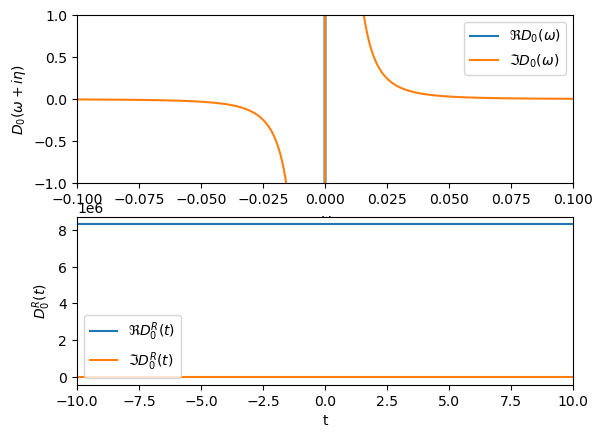

In [11]:
fig,ax = plt.subplots(2)

omega0 = np.sqrt(r)
DR_free_omega = 1./(r - (omega+1j*eta)**2)
#DR_free_omega_left = 0.5/omega0 * (1/(omega +1j*eta + omega0 ))
#DR_free_omega_right = 0.5/omega0 * (-1/(omega + 1j*eta - omega0))
#DR_free_omega = DR_free_omega_left + DR_free_omega_right
DR_free_t = (0.5/np.pi)*freq2time(DR_free_omega,M,dt)
#DR_free_t_left = (0.5/np.pi)*freq2time(DR_free_omega_left,M,dt)
#DR_free_t_right = (0.5/np.pi)*freq2time(DR_free_omega_right,M,dt)
#DR_free_t= DR_free_t_left + DR_free_t_right

ax[0].plot(omega,np.real(DR_free_omega), label = r'$\Re{D_0(\omega)}$')
ax[0].plot(omega,np.imag(DR_free_omega), label = r'$\Im{D_0(\omega)}$')
ax[0].set_xlabel(r'$\omega$')
ax[0].set_ylabel(r'$D_0(\omega+i\eta)$')
ax[0].set_xlim(-0.1,0.1)
ax[0].set_ylim(-1,1)
ax[0].legend(loc = 'upper right')

ax[1].plot(t,np.real(DR_free_t), label = r'$\Re D^R_0(t)$')
ax[1].plot(t,np.imag(DR_free_t), label = r'$\Im D^R_0(t)$')
ax[1].set_xlabel('t')
ax[1].set_ylabel(r'$D_0^R(t)$')
ax[1].set_xlim(-10,10)
ax[1].legend(loc = 'lower left')

''' But wait, shouldn't D_R(t) also be proportional to \theta(t)????? : suspicious '''

In [12]:
DRomega[M:M+5], rhoD[M:M+5], GRomega[M:M+5], rhoG[M:M+5]

(array([-192668.63234339  +4018.78932551j,
        -344035.65362208-167977.66470726j,
         102652.57831026-287251.32382814j,
          -6304.6517542  +16702.69677937j,
          36102.10291744-119647.51374758j]),
 array([ -4018.78934044, 164877.53653564, 284405.55980139, -16853.96430582,
        118523.58870069]),
 array([-0.0127238 -0.09773667j,  0.02386782-0.05932736j,
        -0.00103924-0.05088602j, -0.01493072-0.04265789j,
        -0.0265909 -0.08862188j]),
 array([0.09773667, 0.05932736, 0.05088602, 0.04265789, 0.08862188]))

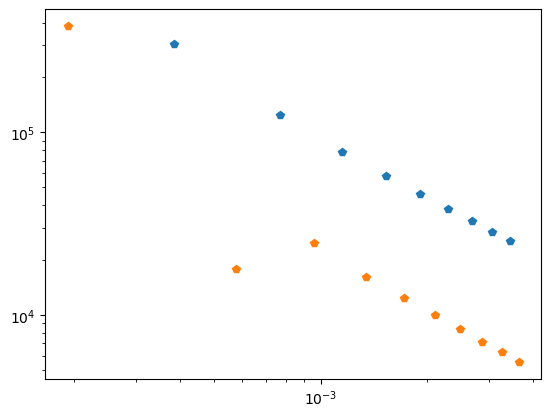

In [13]:
plt.loglog(omega[M:M+20:2], (np.abs(DRomega[M:M+20:2])),'p')
plt.loglog(omega[M+1:M+21:2], 1.001369*(np.abs(DRomega[M+1:M+21:2])),'p')

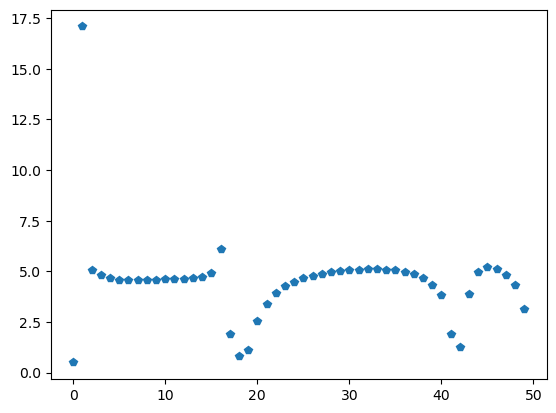

In [14]:
plt.plot((np.abs(DRomega[M:M+100:2]))/(np.abs(DRomega[M+1:M+101:2])),'p')

In [15]:
testarr = np.array([0,1,2,3,4,5])
print(testarr[:2])
testarr[:2] = 0
t[:M], t[M]
print("omega[M] = ", omega[M])
GRt[M-1], GRt[M], GRt[M+1]

[0 1]
omega[M] =  0.0


((-1.1482392185506451e-14+6.904199434387679e-16j),
 (0.0058269920317264075-0.1925329424164781j),
 (0.0033608915423482574-0.5556499952803937j))

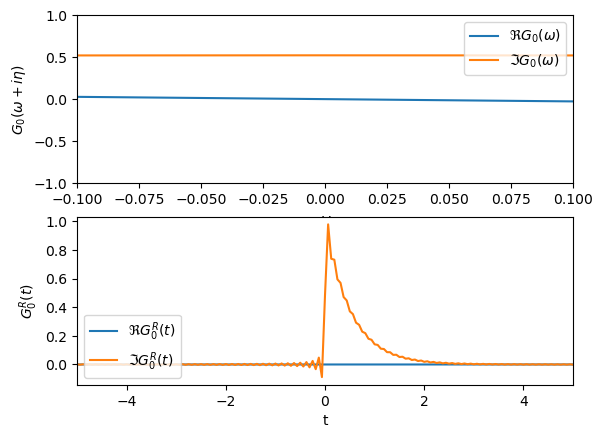

In [16]:
fig,ax = plt.subplots(2)

GR_free_omega = -1./(omega+1j*eta*1000000 - r)
GR_free_t = (0.5/np.pi)*freq2time(GR_free_omega,M,dt)

#Gforw = GR_free_t[M:]
#Grev = GR_free_t[:M]
#Grec = np.concatenate((-1.0*Grev,Gforw))

ax[0].plot(omega,np.real(GR_free_omega), label = r'$\Re{G_0(\omega)}$')
ax[0].plot(omega,np.imag(GR_free_omega), label = r'$\Im{G_0(\omega)}$')
ax[0].set_xlabel(r'$\omega$')
ax[0].set_ylabel(r'$G_0(\omega+i\eta)$')
ax[0].set_xlim(-0.1,0.1)
ax[0].set_ylim(-1,1)
ax[0].legend(loc = 'upper right')


ax[1].plot(t,np.real(GR_free_t), label = r'$\Re G^R_0(t)$')
ax[1].plot(t,np.imag(GR_free_t), label = r'$\Im G^R_0(t)$')
#ax[1].plot(t,np.real(Grec), label = r'$\Re Grec(t)$')
#ax[1].plot(t,np.imag(Grec), label = r'$\Im Grec(t)$')
ax[1].set_xlabel('t')
ax[1].set_ylabel(r'$G_0^R(t)$')
ax[1].set_xlim(-5,5)
ax[1].legend(loc = 'lower left')